In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [59]:
transform = transforms.ToTensor()

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
device = 'cpu'

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [60]:
print(f'Train dataset size:\t {len(train_dataset)}')
print(f'Test dataset size:\t {len(test_dataset)}')

Train dataset size:	 48000
Test dataset size:	 12000


In [61]:
class MPLModel(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[256, 128], output_size=10):
        super(MPLModel, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [62]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epoch_count):
    model.train()
    train_losses, test_losses, test_accuracies = [], [], []
    
    for epoch in range(epoch_count):
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()

            train_loss += loss.item()

        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        
        all_labels, all_predictions = [], []
        test_loss = 0.0
               
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
                predictions = outputs.argmax(dim=1)
                
                all_labels.extend(labels.numpy())
                all_predictions.extend(predictions.numpy())

        test_loss = test_loss / len(test_loader)
        test_accuracy = accuracy_score(all_labels, all_predictions)
        
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'[{epoch+1:02}/{epoch_count:02}]', end='\t\t')
        print(f'{train_loss:.4f}\t\t{test_loss:.4f}\t\t{test_accuracy*100:.2f}%')
    
    return train_losses, test_losses, test_accuracies, all_labels, all_predictions

In [63]:
results = { }
criterion = nn.CrossEntropyLoss()

optimizers = [
    ('SGD', lambda params: optim.SGD(params, lr=0.1), 30),
    ('SGD with Momentum', lambda params: optim.SGD(params, lr=0.05, momentum=0.9), 10),
    ('ADAM', lambda params: optim.Adam(params, lr=0.001), 5)
]

In [64]:
for optimizer_name, optimizer_function, optimizer_epochs in optimizers:
    print(f'\nTraining with: [{optimizer_name}]\n')
    print('Epoch\t\tTrain Loss\tTest Loss\tTest Accuracy')

    model = MPLModel().to(device)
    optimizer = optimizer_function(model.parameters())

    result = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, optimizer_epochs)
    train_losses, test_losses, test_accuracies, labels, predictions = result

    results[optimizer_name] = {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies,
        'labels': labels,
        'predictions': predictions
    }


Training with: [SGD]

Epoch		Train Loss	Test Loss	Test Accuracy
[01/30]		0.5536		0.2522		92.80%
[02/30]		0.2075		0.1643		95.04%
[03/30]		0.1445		0.1280		96.16%
[04/30]		0.1089		0.1151		96.45%
[05/30]		0.0866		0.0928		97.23%
[06/30]		0.0699		0.0911		97.12%
[07/30]		0.0569		0.0811		97.39%
[08/30]		0.0462		0.0730		97.61%
[09/30]		0.0392		0.0763		97.50%
[10/30]		0.0326		0.0712		97.71%
[11/30]		0.0267		0.0655		97.81%
[12/30]		0.0220		0.0680		97.78%
[13/30]		0.0178		0.0672		97.92%
[14/30]		0.0148		0.0720		97.79%
[15/30]		0.0114		0.0693		97.81%
[16/30]		0.0094		0.0667		97.96%
[17/30]		0.0073		0.0694		97.86%
[18/30]		0.0057		0.0659		97.90%
[19/30]		0.0047		0.0677		97.92%
[20/30]		0.0039		0.0679		98.06%
[21/30]		0.0034		0.0702		97.95%
[22/30]		0.0029		0.0704		97.99%
[23/30]		0.0024		0.0702		98.02%
[24/30]		0.0022		0.0694		97.98%
[25/30]		0.0019		0.0703		97.98%
[26/30]		0.0017		0.0712		97.98%
[27/30]		0.0016		0.0712		98.02%
[28/30]		0.0014		0.0716		98.07%
[29/30]		0.0013		0.0722		98.08%
[30/30]

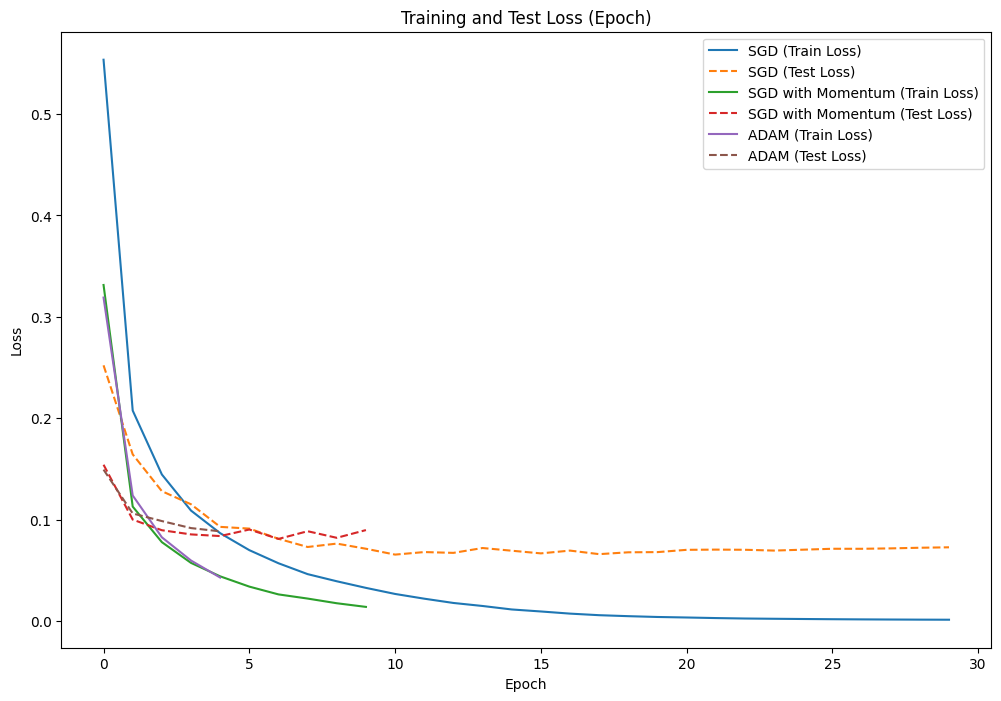

In [65]:
plt.figure(figsize=(12, 8))

for optimizer_name in results:
    plt.plot(results[optimizer_name]['train_losses'], label=f'{optimizer_name} (Train Loss)')
    plt.plot(results[optimizer_name]['test_losses'], linestyle='--', label=f'{optimizer_name} (Test Loss)')

plt.title('Training and Test Loss (Epoch)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

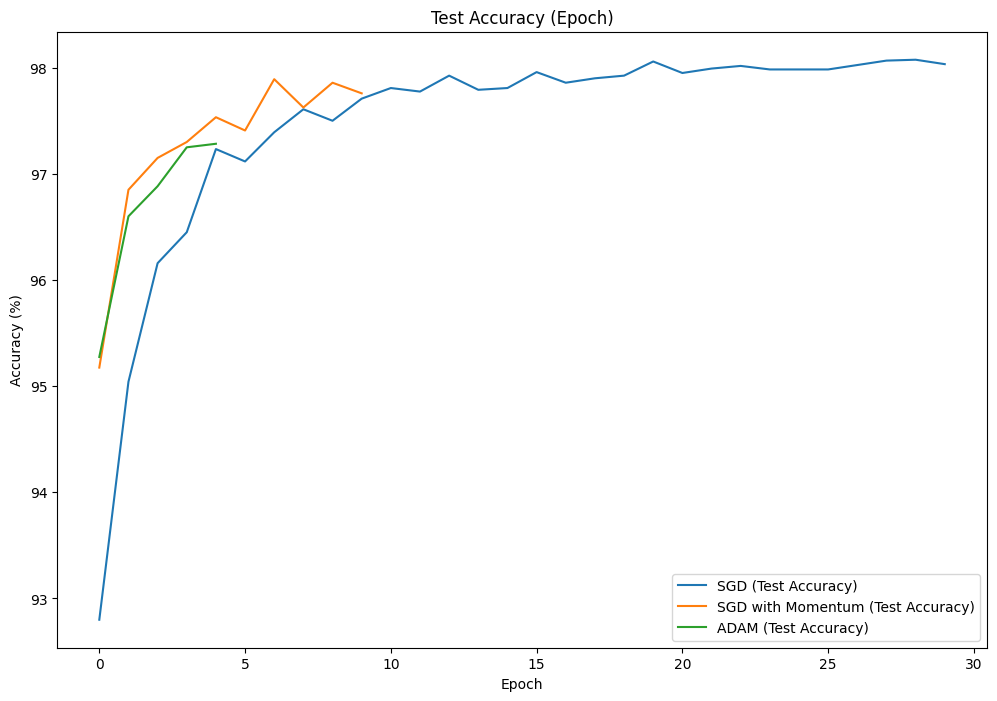

In [66]:
plt.figure(figsize=(12, 8))

for optimizer_name in results:
    plt.plot([a * 100 for a in results[optimizer_name]['test_accuracies']], label=f'{optimizer_name} (Test Accuracy)')

plt.title('Test Accuracy (Epoch)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [67]:
best_optimizer = max(results, key=lambda x: results[x]['test_accuracies'][-1])
labels = results[best_optimizer]['labels']
predictions = results[best_optimizer]['predictions']
cm = confusion_matrix(labels, predictions)

print(f'Best Optimizer: ({best_optimizer})')
print(f'Model Accuracy: {results[best_optimizer]['test_accuracies'][-1]*100:.2f}%')

Best Optimizer: (SGD)
Model Accuracy: 98.03%


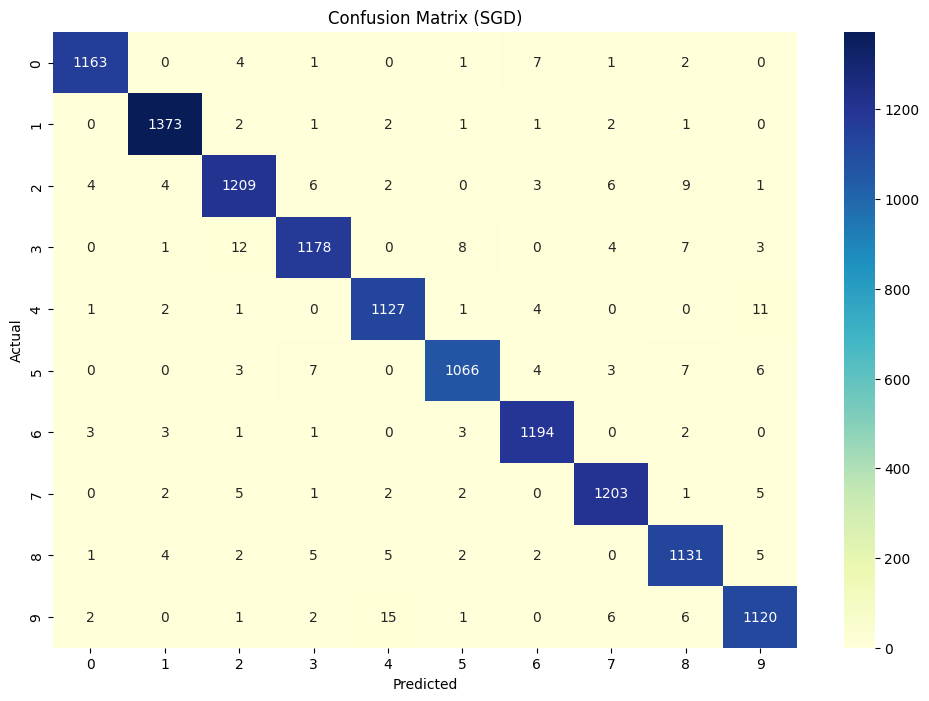

In [68]:
plt.figure(figsize=(12, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=list(range(10)), yticklabels=list(range(10)))

plt.title(f'Confusion Matrix ({best_optimizer})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()